In [1]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

In [2]:
def calculate_metrics(retrieved_lists, gold_lists):
    hits_at_10_count = 0
    hits_at_4_count = 0
    map_at_10_list = []
    mrr_list = []
    ndcg_at_10_list = []
    recall_at_10_list = []

    for retrieved, gold in zip(retrieved_lists, gold_lists):
        hits_at_10_flag = False
        hits_at_4_flag = False
        average_precision_sum = 0
        first_relevant_rank = None
        find_gold = []

        gold = [item.replace(" ", "").replace("\n", "") for item in gold]
        retrieved = [item.replace(" ", "").replace("\n", "") for item in retrieved]

        # Calculate DCG and Recall
        dcg_at_10 = 0
        idcg_at_10 = 0
        relevant_docs_count = len(gold)
    
        for rank, retrieved_item in enumerate(retrieved[:11], start=1):
            if any(gold_item in retrieved_item for gold_item in gold):
                if rank <= 10:
                    hits_at_10_flag = True
                    if first_relevant_rank is None:
                        first_relevant_rank = rank
                    if rank <= 4:
                        hits_at_4_flag = True
                    # Compute precision at this rank for this query
                    count = 0
                    for gold_item in gold:
                        if gold_item in retrieved_item and not gold_item in find_gold:
                            count =  count + 1
                            find_gold.append(gold_item)
                    precision_at_rank = count / rank
                    average_precision_sum += precision_at_rank

                    # Update DCG for relevant document
                    dcg_at_10 += 1 / np.log2(rank + 1)

            # Compute ideal DCG for all relevant documents up to k
            if rank <= relevant_docs_count and relevant_docs_count > 0:
                idcg_at_10 += 1 / np.log2(rank + 1)

        # Recall calculation
        recall_at_10 = len(find_gold) / relevant_docs_count if relevant_docs_count > 0 else 0

        # Calculate metrics for this query
        hits_at_10_count += int(hits_at_10_flag)
        hits_at_4_count += int(hits_at_4_flag)
        map_at_10_list.append(average_precision_sum / min(len(gold), 10))
        mrr_list.append(1 / first_relevant_rank if first_relevant_rank else 0)
        ndcg_at_10_list.append(dcg_at_10 / idcg_at_10 if idcg_at_10 > 0 else 0)
        recall_at_10_list.append(recall_at_10)

    # Calculate average metrics over all queries
    hits_at_10 = hits_at_10_count / len(gold_lists)
    hits_at_4 = hits_at_4_count / len(gold_lists)
    map_at_10 = sum(map_at_10_list) / len(gold_lists)
    mrr_at_10 = sum(mrr_list) / len(gold_lists)
    ndcg_at_10 = sum(ndcg_at_10_list) / len(gold_lists)
    recall_at_10 = sum(recall_at_10_list) / len(gold_lists)

    return {
        'Hits@10': hits_at_10,
        'Hits@4': hits_at_4,
        'MAP@10': map_at_10,
        'MRR@10': mrr_at_10,
        'NDCG@10': ndcg_at_10,
        'Recall@10': recall_at_10
    }, map_at_10_list, mrr_list


def main_eval(file_name):
    print(f'For file: {file_name}')
    with open(file_name, 'r') as file:
        data = json.load(file)
    retrieved_lists = []
    gold_lists  = []

    for d in data:
        if d['question_type'] == 'null_query':
            continue
        retrieved_lists.append([m['text'] for m in d['retrieval_list']])
        gold_lists.append([m['fact'] for m in d['gold_list']])     

    # Calculate metrics
    metrics, map_at_10_list, mrr_list = calculate_metrics(retrieved_lists, gold_lists)

    # Print the metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
        
    print('-'*20)

    # Plot Box Plot for AP and RR scores
    plot_box(map_at_10_list, mrr_list)

def plot_box(map_at_10_list, mrr_list):
    data = [map_at_10_list, mrr_list]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.boxplot(data, patch_artist=True, labels=['AP@10', 'MRR@10'])
    ax.set_title('Box Plot of AP@10 and MRR@10')
    ax.set_ylabel('Score')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(mrr_list, bins=20, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Distribution of MRR@10')
    plt.xlabel('MRR@10 Values')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)  # Set x-axis limits for clarity
    plt.grid(axis='y')
    plt.show()

For file: output/baai_llm_embedder_reranker.json
Hits@10: 0.6204
Hits@4: 0.5410
MAP@10: 0.2149
MRR@10: 0.4936
NDCG@10: 0.6614
Recall@10: 0.2989
--------------------


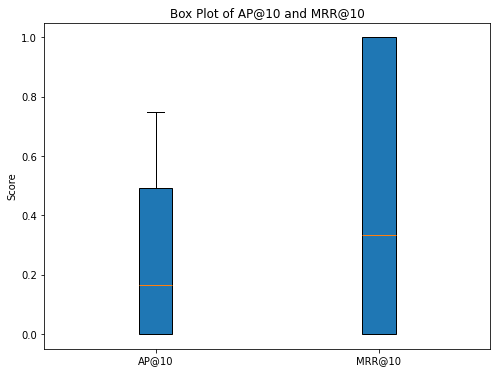

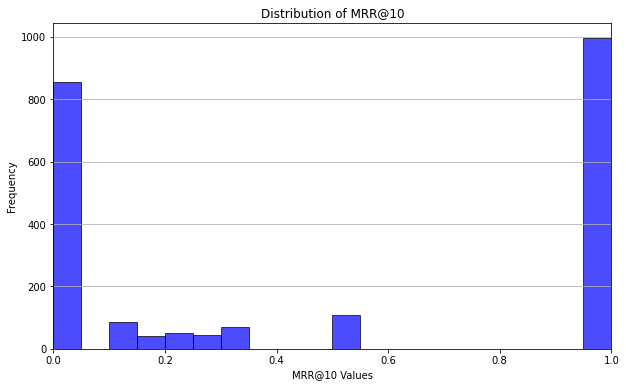

In [3]:
main_eval('output/baai_llm_embedder_reranker.json')

For file: output/all_mpnet_base_v2.json
Hits@10: 0.4523
Hits@4: 0.3224
MAP@10: 0.1169
MRR@10: 0.2645
NDCG@10: 0.3833
Recall@10: 0.2135
--------------------


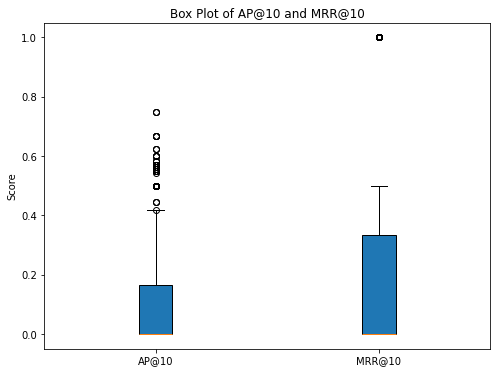

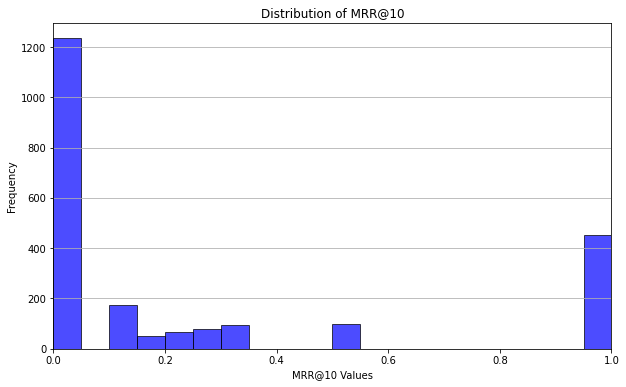

In [4]:
main_eval('output/all_mpnet_base_v2.json')

For file: output/bm25_ranking.json
Hits@10: 0.5060
Hits@4: 0.4098
MAP@10: 0.1505
MRR@10: 0.3293
NDCG@10: 0.2344
Recall@10: 0.2646
--------------------


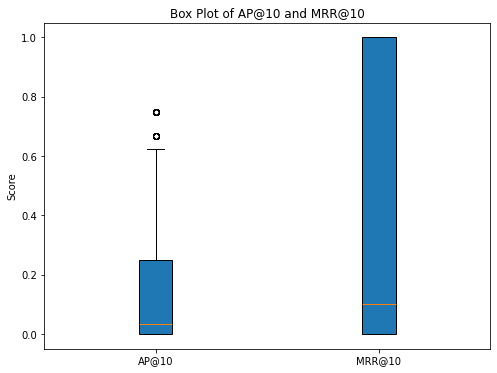

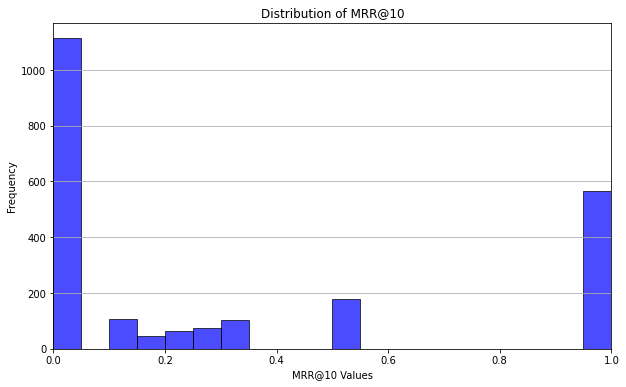

In [5]:
main_eval('output/bm25_ranking.json')

For file: output/baai_llm_embedder.json
Hits@10: 0.5348
Hits@4: 0.4018
MAP@10: 0.1408
MRR@10: 0.3299
NDCG@10: 0.4690
Recall@10: 0.2499
--------------------


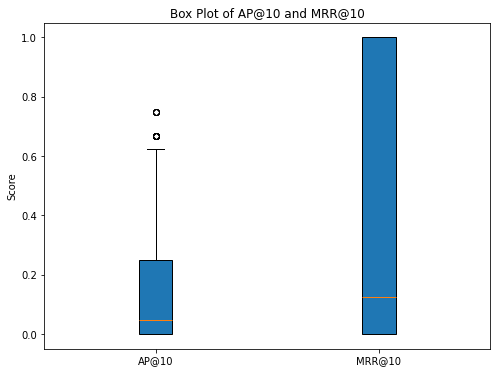

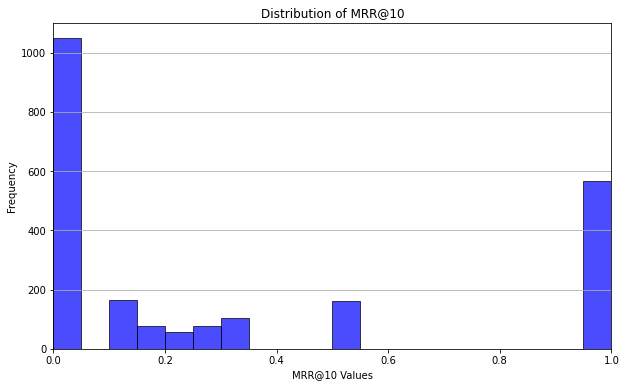

In [6]:
main_eval('output/baai_llm_embedder.json')